Self Repair as Done in the Original Paper

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tf_perturb.dataset import prepare_dataset
from transformer_lens import HookedTransformer
import torch

model = HookedTransformer.from_pretrained("gpt2-small")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

TOTAL_TOKENS = 1000
BATCH_SIZE = 2
PROMPT_LEN = 100
padding = False

dataset = prepare_dataset(model, device, TOTAL_TOKENS, BATCH_SIZE, PROMPT_LEN, padding, dataset_name="pile")

/Users/solar/miniconda3/envs/pytorch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
from tf_perturb.self_healing_orig import SelfRepairConfig, SelfRepairPipeline


# 1. Configure the pipeline
config = SelfRepairConfig(
    model_name="gpt2-small", 
    dataset_name="pile",
    batch_size=4, # Adjust batch size based on GPU memory
    min_tokens=500, # Smaller run for example
    percentile=0.05,
    save_results=True,
    save_folder="data/self_repair_orig/self_repair_results/"
    # Add/modify other configurations as needed
)

In [11]:
# 2. Create and run the pipeline
pipeline = SelfRepairPipeline(config)
results = pipeline.run()

Using device: mps
Initializing model...
Loaded pretrained model gpt2-small into HookedTransformer
Initializing data loader...
Initializing calculator...
Computing raw metrics...



Processing batches:   0%|          | 0/2 [05:37<?, ?it/s]


Processing batches: 100%|██████████| 2/2 [00:53<00:00, 26.62s/it]


Finished computing raw metrics.
Computing aggregated metrics...
Selecting top 5.00% instances (39)...


Aggregating Condensed: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Aggregating Full...


Aggregating Full: 100%|██████████| 15/15 [00:00<00:00, 34.70it/s]

Finished computing aggregated metrics.
Saving results to data/self_repair_orig/self_repair_results/...
Finished saving results.
Pipeline finished.


In [60]:
list(results.keys())[:10]
def plot_head_results(results_tensor, title="Head Results", cmap="viridis", figsize=(10, 8), 
                      vmin=None, vmax=None, colorbar_label="Value"):
    """
    Plot a scatter plot of head results with layer-based coloring.
    
    Args:
        results_tensor: Tensor of shape [n_layers, n_heads] containing results to plot
        title: Title for the plot
        cmap: Colormap to use
        figsize: Figure size as (width, height)
        vmin, vmax: Min and max values for color scaling
        colorbar_label: Label for the colorbar
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Convert tensor to numpy if needed
    if isinstance(results_tensor, torch.Tensor):
        results_tensor = results_tensor.cpu().numpy()
    
    n_layers, n_heads = results_tensor.shape
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create points for each head
    for layer in range(n_layers):
        for head in range(n_heads):
            value = results_tensor[layer, head]
            # Color based on layer position (normalized from 0 to 1)
            color = layer / (n_layers - 1) if n_layers > 1 else 0.5
            
            # Handle potential negative or zero values for LogNorm
            if vmin is None or vmax is None:
                # Use regular normalization if vmin/vmax not specified
                scatter = ax.scatter(layer, head, c=[value], cmap=cmap, 
                                    s=100, edgecolors='black')
            else:
                # Ensure positive values for LogNorm to avoid "Invalid vmin or vmax" error
                safe_vmin = max(1e-10, vmin) if vmin <= 0 else vmin
                safe_vmax = max(safe_vmin * 1.1, vmax)  # Ensure vmax > vmin
                
                from matplotlib.colors import LogNorm
                scatter = ax.scatter(layer, head, c=[value], cmap=cmap, 
                                    s=100, edgecolors='black',
                                    norm=LogNorm(vmin=safe_vmin, vmax=safe_vmax))
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(colorbar_label)
    
    # Set labels and title
    ax.set_xlabel('Layer')
    ax.set_ylabel('Head')
    ax.set_title(title)
    
    # Set axis limits with some padding
    ax.set_xlim(-0.5, n_layers - 0.5)
    ax.set_ylim(-0.5, n_heads - 0.5)
    
    # Set integer ticks for layers and heads
    ax.set_xticks(range(n_layers))
    ax.set_yticks(range(n_heads))
    
    plt.tight_layout()
    return fig, ax

In [46]:
list(results.keys())

['condensed_logit_diffs',
 'condensed_direct_effects',
 'condensed_ablated_direct_effects',
 'condensed_self_repair_from_heads',
 'condensed_self_repair_from_layers',
 'condensed_self_repair_from_LN',
 'condensed_self_repair',
 'condensed_percent_LN_of_DE',
 'condensed_percent_heads_of_DE',
 'condensed_percent_layers_of_DE',
 'condensed_percent_self_repair_of_DE',
 'full_logit_diffs',
 'full_direct_effects',
 'full_ablated_direct_effects',
 'full_self_repair_from_heads',
 'full_self_repair_from_layers',
 'full_self_repair_from_LN',
 'full_self_repair',
 'full_percent_LN_of_DE',
 'full_percent_heads_of_DE',
 'full_percent_layers_of_DE',
 'full_percent_self_repair_of_DE',
 'full_unclipped_percent_LN_of_DE',
 'full_unclipped_percent_heads_of_DE',
 'full_unclipped_percent_layers_of_DE',
 'full_unclipped_percent_self_repair_of_DE']

Processing batches:   0%|          | 0/2 [1:29:34<?, ?it/s]


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'condensed_self_repair_from_LN'}, xlabel='Layer', ylabel='Head'>)

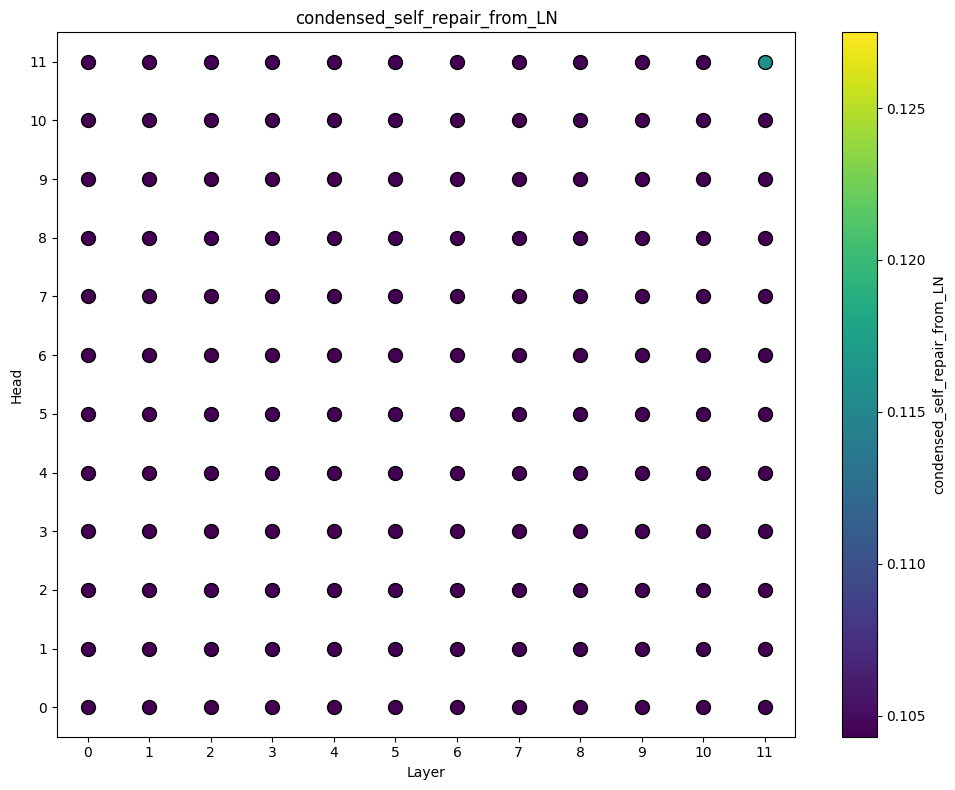

In [48]:
# Example usage:
key = 'condensed_self_repair_from_LN'
plot_head_results(results[key], 
                 title=key, 
                 colorbar_label=key)

In [16]:
results['full_self_repair_from_heads'].shape

torch.Size([12, 12])

In [ ]:
from tf_perturb.self_healing_new import SelfRepairConfigNew, SelfRepairPipelineNew

config = SelfRepairConfigNew(
    model_name="gpt2-small", 
    dataset_name="pile",
    batch_size=4, # Adjust batch size based on GPU memory
    prompt_len=20,
)
pipeline = SelfRepairPipelineNew(config)
results = pipeline.run()


Using device: mps
Initializing model...
Loaded pretrained model gpt2-small into HookedTransformer
Initializing data loader...


Map (num_proc=10):   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80023 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (92793 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (90016 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (102873 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (96179 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequenc

DataLoader initialized: 13 batches, 52 total prompts.
Initializing calculator...
Initialized raw tensors: ['direct_effects', 'logit_clean_score', 'logit_ablated_score', 'logit_iso_ablated_score', 'self_repair_new']
Computing raw metrics (New Method)...


Processing batches: 100%|██████████| 13/13 [03:14<00:00, 14.96s/it]


Finished computing raw metrics (New Method).
Computing aggregated metrics (New Method)...
Selecting top 2.00% DE instances (19)...


Aggregating Condensed: 100%|██████████| 12/12 [00:00<00:00, 18.56it/s]


Aggregating Full...


Aggregating Full: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]

Finished computing aggregated metrics (New Method).
Saving results to data/pickle_storage/new_self_repair/...
Finished saving results to data/pickle_storage/new_self_repair/
Pipeline finished.


KeyError: 'full_self_repair'

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'full_self_repair_new'}, xlabel='Layer', ylabel='Head'>)

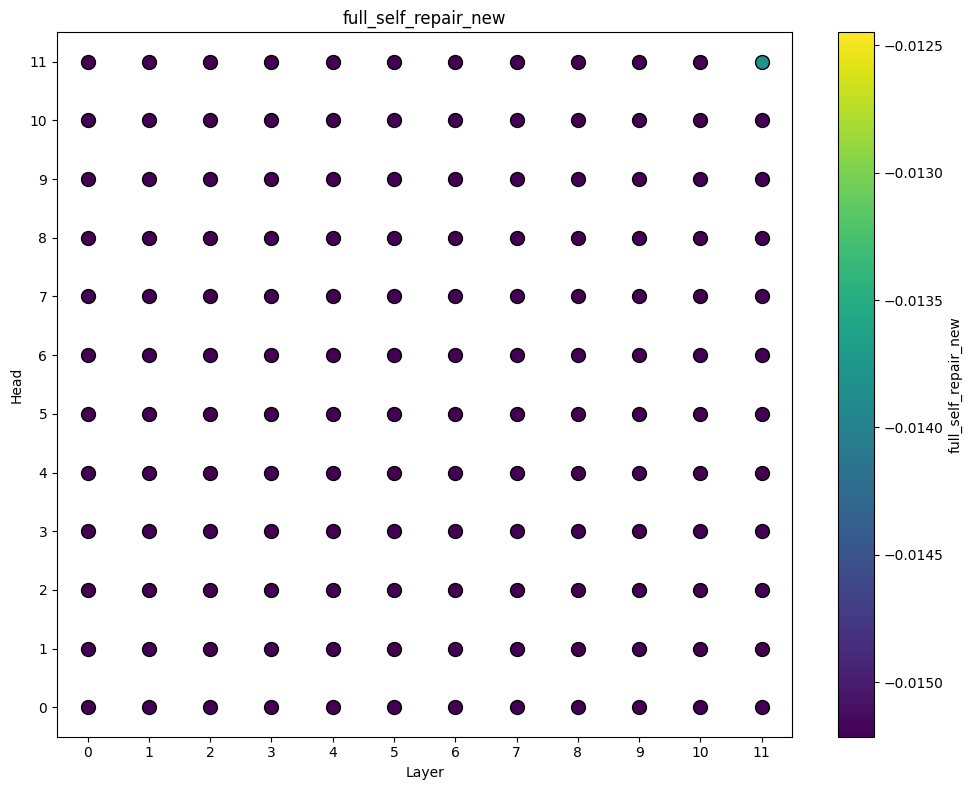

In [62]:
list(results.keys())
key = 'full_self_repair_new'
plot_head_results(results[key], 
                 title=key, 
                 colorbar_label=key)